In [3]:
import jax
from jax import numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import os

SEED = 1234
np.random.seed(SEED)
key = jax.random.PRNGKey(SEED)

In [108]:
def params_init(layers_size):
    params = []
    for i in range(len(layers_size) - 1):
        # Initialize weights using He initialization
        W = jnp.array(
            np.random.normal(
                0.0,
                jnp.sqrt(2 / (layers_size[i] + layers_size[i + 1])),
                (layers_size[i + 1], layers_size[i]),
            )
        )
        # Initialize biases to zeros
        b = jnp.zeros((layers_size[i + 1], 1))
        
        # Add weights and biases to the parameters list
        params.extend([W, b])

    return params

def ANN(x, params):
    layer = x.T  # Transpose input for matrix multiplication
    for i in range(0, len(params), 2):
        W = params[i]  # Weights
        b = params[i + 1]  # Biases

        # Linear transformation
        layer = jnp.dot(W, layer) + b

        # Apply activation function
        if i < len(params) - 2:  # Hidden layers
            layer = jax.nn.relu(layer)  # ReLU activation
        else:  # Output layer
            layer = jax.nn.sigmoid(layer)

    return layer.T  # Transpose back to original shape

In [109]:
@jax.jit
def cross_entropy_loss(gen_params, x, labels):
    y = ANN(x, gen_params)

    # Compute binary cross entropy with clipping to avoid NaN values
    return -jnp.mean(labels * jnp.log(y + 1e-7) + (1 - labels) * jnp.log(1 - y + 1e-7))

# Compute gradient loss
cross_loss_grad = jax.jit(jax.grad(cross_entropy_loss, argnums=0))

In [110]:
def SGD(params, x, y, lr):
    grad = cross_loss_grad(params, x, y)

    # Update weights and biases
    for i in range(len(params)):
        params[i] = params[i] - lr * grad[i]
    
    return params

In [111]:
layers_size = [256, 128, 128, 128, 256]
batch_size = 32
lr = 0.0001
num_epochs = 3000

ann_params = params_init(layers_size)

# Initialize loss history
loss_history = []

In [112]:
import json

"""
    {
        script_name: {
            "bytes": [[252], [72, ... 240] ... [104, 126, 162, 208, 83]],
            "data_addresses": [48, 50, 52, ... 526, 528]
        }

        ...
    }
    """

def load_data(path):
    with open(path, 'r') as f:
        data = json.load(f)
        
    result = []
    for script_name, script_data in data.items():
        try:
            bytes = script_data['bytes']
            flattened_bytes = [b for instruction in bytes for b in instruction]
            
            data_addresses = script_data['data_addresses']
            
            x = jnp.array(flattened_bytes)
            
            y = np.zeros_like(x)
            y[data_addresses] = 1
            y = jnp.array(y)
        except:
            continue

        result.append((script_name, x, y))

    return result

data = load_data('payloads_dict.json')

script_name, x, y = data[0]
print(script_name, x.shape, y.shape)

windows_x64_shell_bind_tcp_rc4.bin (571,) (571,)


In [113]:
def sliding_window_data(x, y, window_size, step_size=1):
    inputs, labels = [], []
    for i in range(0, len(x) - window_size + 1, step_size):
        input_window = x[i:i + window_size]
        label_window = y[i:i + window_size] 
        inputs.append(input_window)
        labels.append(label_window)

    inputs = jnp.array(inputs)
    labels = jnp.array(labels)
    
    return inputs, labels

window_size = 256
step_size = 1
inputs, labels = sliding_window_data(x, y, window_size, step_size)
print(inputs.shape, labels.shape)

(316, 256) (316, 256)


In [114]:
validation_data = data[4]
_, val_x, val_y = validation_data
val_inputs, val_labels = sliding_window_data(val_x, val_y, window_size, step_size)
print(val_inputs.shape, val_labels.shape)

(305, 256) (305, 256)


In [115]:
# Calculate the number of batches
num_batches = len(inputs) // batch_size

for epoch in range(num_epochs):
    # Shuffle dataset and generate latent vectors for the entire dataset
    key, shuffle_key = jax.random.split(key)
    
    idxs = jax.random.permutation(shuffle_key, jnp.arange(inputs.shape[0]))
    inputs = inputs[idxs]
    labels = labels[idxs]

    # Train generator
    for i in range(num_batches):
        # Get a batch of real images and labels
        train_batch = inputs[i * batch_size:(i + 1) * batch_size]
        labels_batch = labels[i * batch_size:(i + 1) * batch_size]

        # SGD
        ann_params = SGD(ann_params, train_batch, labels_batch, lr)

    loss = cross_entropy_loss(ann_params, inputs, labels)

    # Store the losses in the history
    loss_history.append(loss)
    print(f"Epoch {epoch}, loss: {loss:.4f}")

    if (epoch+1) % 10 == 0:
        # print accuracy
        y_pred = ANN(val_inputs, ann_params)
        y_pred = jnp.round(y_pred)

        TP = jnp.sum(jnp.logical_and(y_pred == 1, val_labels == 1))
        TN = jnp.sum(jnp.logical_and(y_pred == 0, val_labels == 0))
        FP = jnp.sum(jnp.logical_and(y_pred == 1, val_labels == 0))
        FN = jnp.sum(jnp.logical_and(y_pred == 0, val_labels == 1))

        print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

Epoch 0, loss: 6.9844
Epoch 1, loss: 6.8973
Epoch 2, loss: 6.8106
Epoch 3, loss: 6.7242
Epoch 4, loss: 6.6390
Epoch 5, loss: 6.5549
Epoch 6, loss: 6.4740
Epoch 7, loss: 6.3980
Epoch 8, loss: 6.3237
Epoch 9, loss: 6.2521
TP: 692, TN: 39369, FP: 37383, FN: 636
Epoch 10, loss: 6.1826
Epoch 11, loss: 6.1144
Epoch 12, loss: 6.0484
Epoch 13, loss: 5.9842
Epoch 14, loss: 5.9214
Epoch 15, loss: 5.8604
Epoch 16, loss: 5.8000
Epoch 17, loss: 5.7416
Epoch 18, loss: 5.6839
Epoch 19, loss: 5.6282
TP: 634, TN: 42334, FP: 34418, FN: 694
Epoch 20, loss: 5.5740
Epoch 21, loss: 5.5212
Epoch 22, loss: 5.4696
Epoch 23, loss: 5.4197
Epoch 24, loss: 5.3715
Epoch 25, loss: 5.3245
Epoch 26, loss: 5.2792
Epoch 27, loss: 5.2353
Epoch 28, loss: 5.1930
Epoch 29, loss: 5.1522
TP: 593, TN: 44669, FP: 32083, FN: 735
Epoch 30, loss: 5.1122
Epoch 31, loss: 5.0734
Epoch 32, loss: 5.0359
Epoch 33, loss: 4.9994
Epoch 34, loss: 4.9637
Epoch 35, loss: 4.9294
Epoch 36, loss: 4.8951
Epoch 37, loss: 4.8618
Epoch 38, loss: 4.8

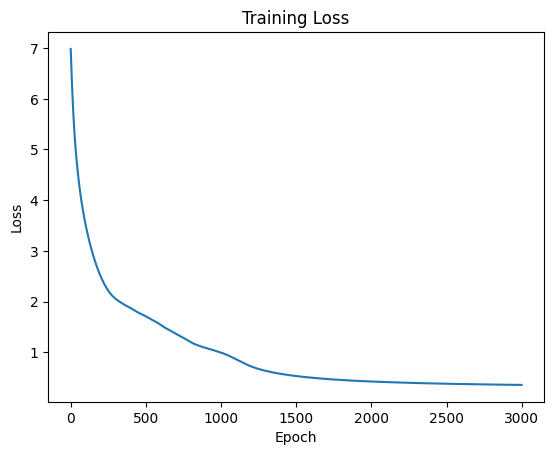

In [116]:
# Plot loss history
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()